In [1]:
# Make the necessary imports.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import griddb_python as griddb
from prophet import Prophet

# import the dataset
data = pd.read_csv('/home/ali/griddb_experiments/daily-temperature-dataset/daily-minimum-temperatures.csv')
data.head(5)

Importing plotly failed. Interactive plots will not work.


,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [2]:
# Check Null Values and Drop Unknown Values.
print(f'------------Null Values within The Dateset------------- \n{data.isnull().sum()}')

# Pick only Floating point number as it is string right now from Min Temperature to convert it into numeric.
data['Daily minimum temperatures'] = data['Daily minimum temperatures'].str.extract('(\d+\.?\d*)')[0]

------------Null Values within The Dateset------------- 
Date                          0
Daily minimum temperatures    0
dtype: int64


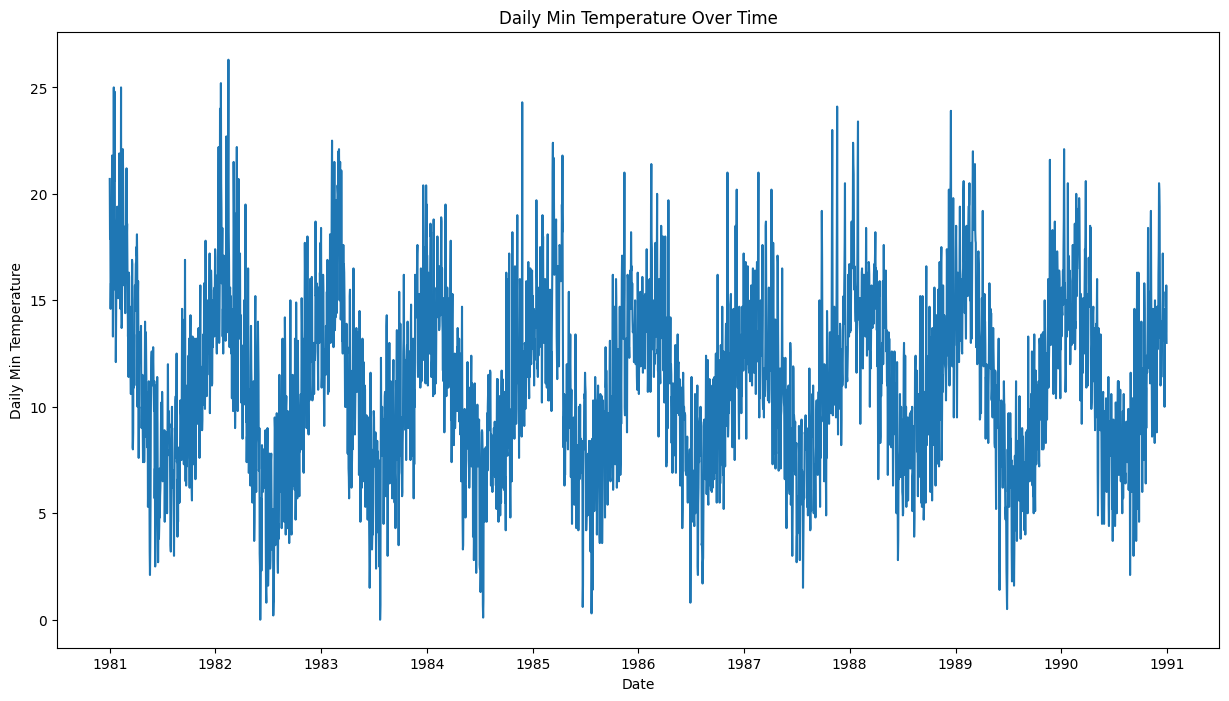

In [3]:
# plot the trend of temperatures over time using lineplot.
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Convert temperature column to numeric
data['Daily minimum temperatures'] = pd.to_numeric(data['Daily minimum temperatures'])

# Convert the date into pandas DateTime format.
def plot_trend(data) -> None:
    plt.figure(figsize=(15,8))
    sns.lineplot(data=data,x='Date',y='Daily minimum temperatures')
    plt.xlabel('Date')
    plt.ylabel('Daily Min Temperature')
    plt.title('Daily Min Temperature Over Time')
    plt.show()

    return None

plot_trend(data)

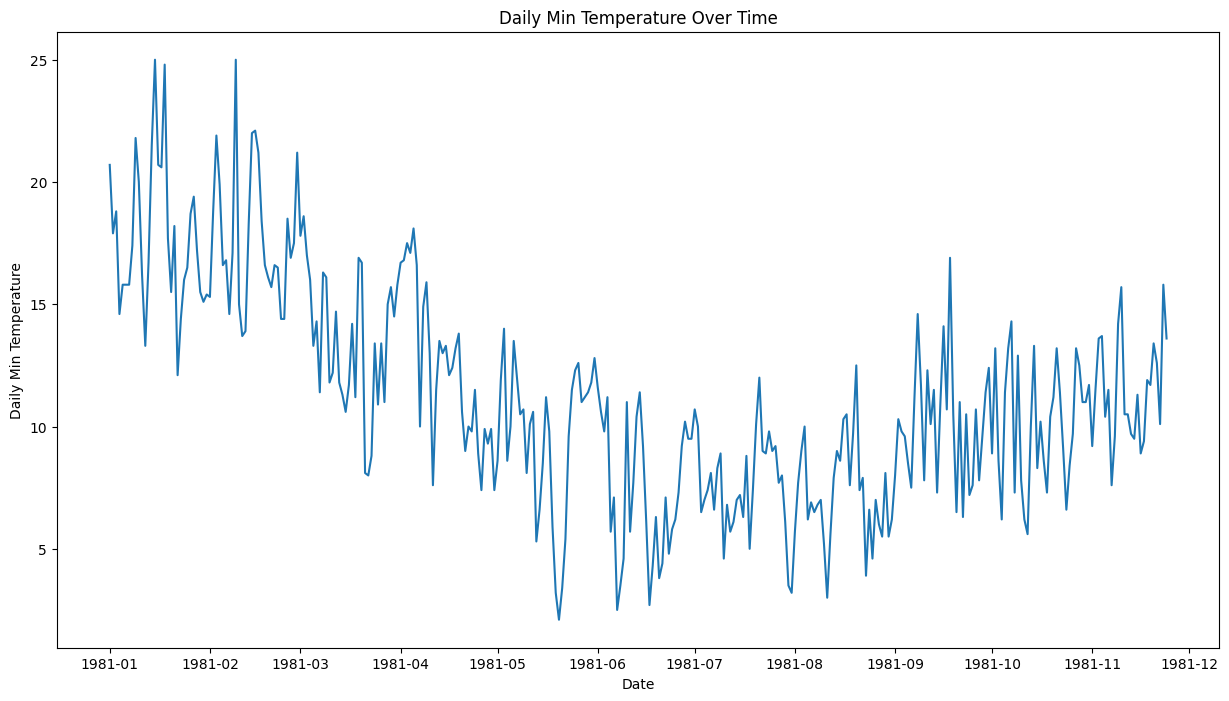

In [4]:
# Let's That a look at only 5 percent of the trend to understand it better.
plot_trend(data[:int(0.09*len(data))])

In [5]:
# It shows us that over the span of months of a year, the daily min temp is usually highest in January and tends to go down till 
# 7th month and then rises again, and this sort of trend could be seen for each year. however as the time passes the daily min temp
# of 1991 is much lower in january as compared to daily min temp in 1981 January.

# Now we need to insert our Dataset into GridDb Cluster.
# lets connect ot griddb.

factory = griddb.StoreFactory.get_instance()

try:
    gridstore=factory.get_store(host="239.0.0.1", port=int("31999"), 
                                 cluster_name="Cluster1", username="admin", password="ali1234")

    # Create a new Collection of Store.
    coninfo = griddb.ContainerInfo("Daily-Temp",
                                   [
                                       ["Date", griddb.Type.TIMESTAMP],
                                       ["Daily-minimum-temperatures", griddb.Type.FLOAT]
                                   ],
                                   type=griddb.ContainerType.TIME_SERIES)
    
    container1 = gridstore.get_container("Daily-Temp")
    if container1 == None:
       print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
   for i in range(e.get_error_stack_size()):
       print("[", i, "]")
       print(e.get_error_code(i))
       print(e.get_location(i))
       print(e.get_message(i))

Successfully connected to GridDB


In [14]:
# Create a Container if does not exist.

try:
    container = gridstore.put_container(coninfo)
    cont = gridstore.get_container("Daily-Temp")
    print(f"Container Created Successfully")
except griddb.GSException as e:
   for i in range(e.get_error_stack_size()):
       print("[", i, "]")
       print(e.get_error_code(i))
       print(e.get_location(i))
       print(e.get_message(i))

Container Created Successfully


In [15]:
# Put Data into Grid DataBase.
try:
    for index,row in data.iterrows():
        cont.put([row["Date"],row["Daily minimum temperatures"]])
    print(f"Insertion Completed Succussfully.")
except griddb.GSException as e:
   for i in range(e.get_error_stack_size()):
       print("[", i, "]")
       print(e.get_error_code(i))
       print(e.get_location(i))
       print(e.get_message(i)) 

Insertion Completed Succussfully.


In [13]:
# Retrive Data from Grid Db for Model.
try:
    temperature_container = gridstore.get_container("Daily-Temp")
    query = temperature_container.query("select *")
    rs = query.fetch()
    rows=rs.fetch_rows()
except griddb.GSException as e:
   for i in range(e.get_error_stack_size()):
       print("[", i, "]")
       print(e.get_error_code(i))
       print(e.get_location(i))
       print(e.get_message(i))

In [14]:
# Check retrived Data First 5 rows.
data = rows
data.reset_index(drop=True)
data.head(5)

,Date,Daily-minimum-temperatures
0,1981-01-01,20.700001
1,1981-01-02,17.900000
2,1981-01-03,18.799999
3,1981-01-04,14.600000
4,1981-01-05,15.800000


In [15]:
# Prepare Data Format for Prophet model.
prophet_df = pd.DataFrame(data={
    'ds' : data['Date'],
    'y': data['Daily-minimum-temperatures']
})

# Update its pre-generated index column and reomve it.
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

In [16]:
prophet_df.head(5)

,ds,y
0,1981-01-01,20.700001
1,1981-01-02,17.900000
2,1981-01-03,18.799999
3,1981-01-04,14.600000
4,1981-01-05,15.800000


In [17]:
# Splitting the Dataset into Train/Test Split and Training the Model.
TRAIN_SPLIT=0.7

train_data = prophet_df[:int(0.7*len(data))]
test_data = prophet_df[int(0.7*len(data)):]

In [18]:
print(len(train_data))
print(len(test_data))

2555
1095


In [19]:
# Train the Model on Train set.

# Trend Checks.
DAILY_CHECK=True
WEEKLY_CHECK=False
YEARLY_CHECK=True

# model = Prophet(
#     seasonality_mode='additive',
#     daily_seasonality=DAILY_CHECK,
#     weekly_seasonality=WEEKLY_CHECK,
#     yearly_seasonality=YEARLY_CHECK,
#     changepoint_prior_scale=0.05,  # Controls flexibility of trend
#     seasonality_prior_scale=10     # Controls strength of seasonality
# )

# model.fit(train_data)

model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False,  # We'll add custom yearly
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.15,
    seasonality_prior_scale=3.0
)

# Add custom yearly seasonality with more Fourier terms
model.add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=15,  # More terms = more flexible seasonal pattern
    prior_scale=5.0
)

# Add semi-annual pattern (some regions have two temperature peaks)
model.add_seasonality(
    name='semi_yearly',
    period=365.25/2,
    fourier_order=5,
    prior_scale=2.0
)

model.fit(train_data)

18:55:11 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Now Lets Make Predictions and Evaluate.

def make_predictions(model,periods,freq='D'):
    future = model.make_future_dataframe(periods=periods,freq='D')
    forecast = model.predict(future)
    print(f"Length of ForeCast: {len(forecast)}")
    test_forecast = forecast.tail(periods).copy()

    median = test_forecast['yhat'].values           # Main prediction
    lower = test_forecast['yhat_lower'].values      # Lower bound
    upper = test_forecast['yhat_upper'].values      # Upper bound
    
    return lower, median, upper, test_forecast

def evaluate_model(pred,ground_truth,model_name="Prophet"):
    # Evaluate predictions with Ground truth.
    mae = mean_absolute_error(ground_truth, pred)
    rmse = np.sqrt(mean_squared_error(ground_truth, pred))

    print(f"\n{model_name} Model Performance:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    return mae, rmse

# Make Predictions.
lower_bound, pred , upper_bound , forecast = make_predictions(model,periods=len(test_data))
# Evaluate Model.
evaluate_model(pred=pred,ground_truth=test_data['y'].values)

Length of ForeCast: 3650

Prophet Model Performance:
MAE:  2.09
RMSE: 2.67


(2.0874367155988356, np.float64(2.6735657740934413))

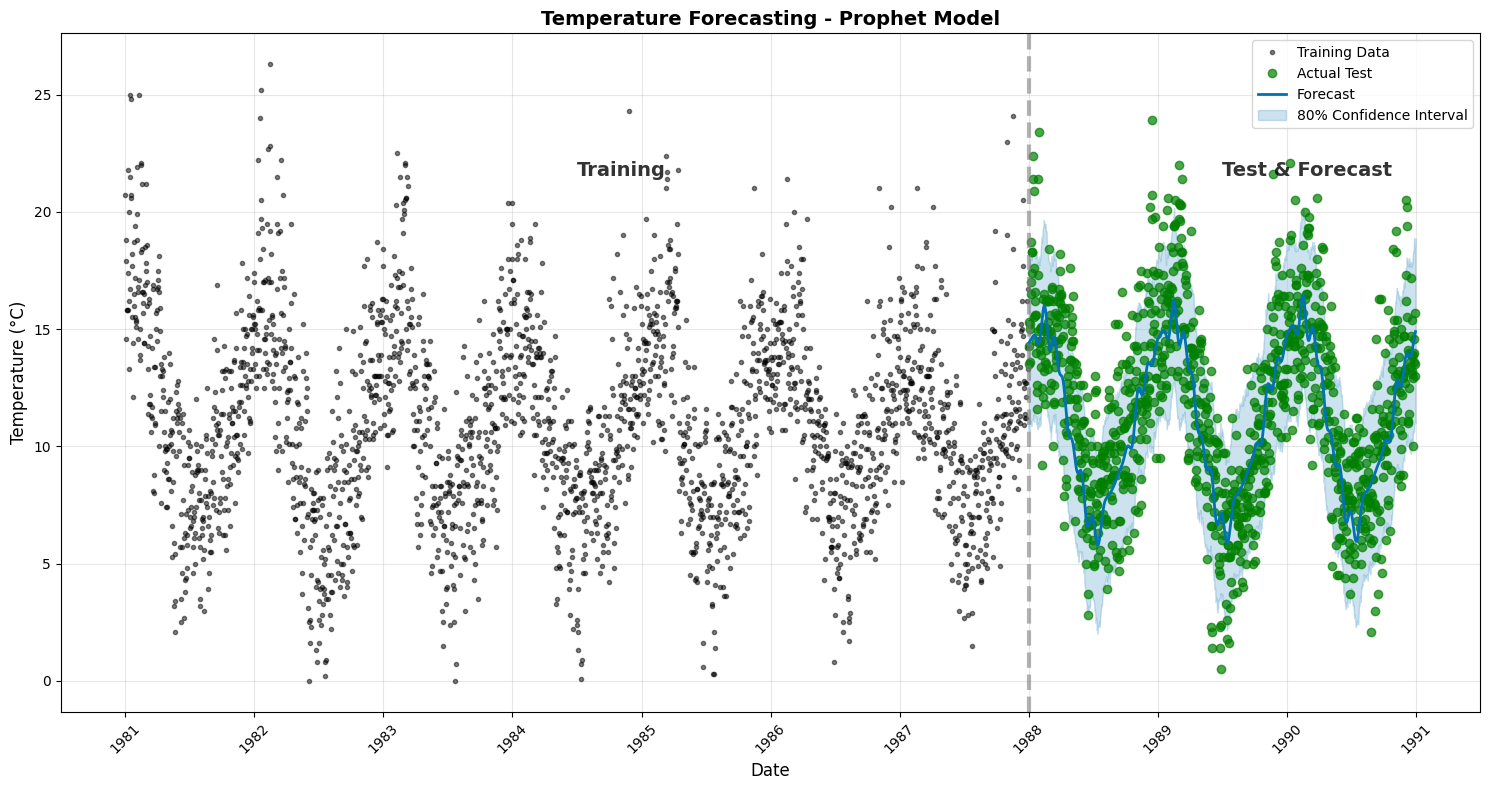

In [27]:
#Plot Time Series Graph Showing Train Part, Test Part and Predicted Part.
def complete_plot_timeseries(pred, test_data, train_data=None, lower_bound=None, upper_bound=None):
    fig = plt.figure(facecolor='w', figsize=(15, 8))
    ax = fig.add_subplot(111)
    
    # Plot training data as black dots
    if train_data is not None:
        ax.plot(train_data['ds'].values, train_data['y'], 'k.', alpha=0.5, label="Training Data")
    
    # Plot test data as green dots
    ax.plot(test_data['ds'].values, test_data['y'], 'go', alpha=0.7, label="Actual Test")
    
    # Plot predictions as blue line
    ax.plot(test_data['ds'].values, pred, ls='-', c='#0072B2', linewidth=2, label="Forecast")
    
    # Fill confidence interval
    if lower_bound is not None and upper_bound is not None:
        ax.fill_between(test_data['ds'].values, lower_bound, upper_bound, 
                       color='#0072B2', alpha=0.2, label="80% Confidence Interval")
    
    # Add vertical line to show train/test split
    if train_data is not None:
        cutoff_date = test_data['ds'].iloc[0]
        ax.axvline(x=cutoff_date, color='gray', lw=3, alpha=0.6, linestyle='--')
        
        # Add text annotations
        ax.text(x=train_data['ds'].iloc[len(train_data)//2], y=test_data['y'].max()*0.9, 
               s='Training', color='black', fontsize=14, fontweight='bold', alpha=0.8)
        ax.text(x=test_data['ds'].iloc[len(test_data)//2], y=test_data['y'].max()*0.9, 
               s='Test & Forecast', color='black', fontsize=14, fontweight='bold', alpha=0.8)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title('Temperature Forecasting - Prophet Model', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return None

complete_plot_timeseries(pred=pred,test_data=test_data,train_data=train_data,lower_bound=lower_bound,upper_bound=upper_bound)

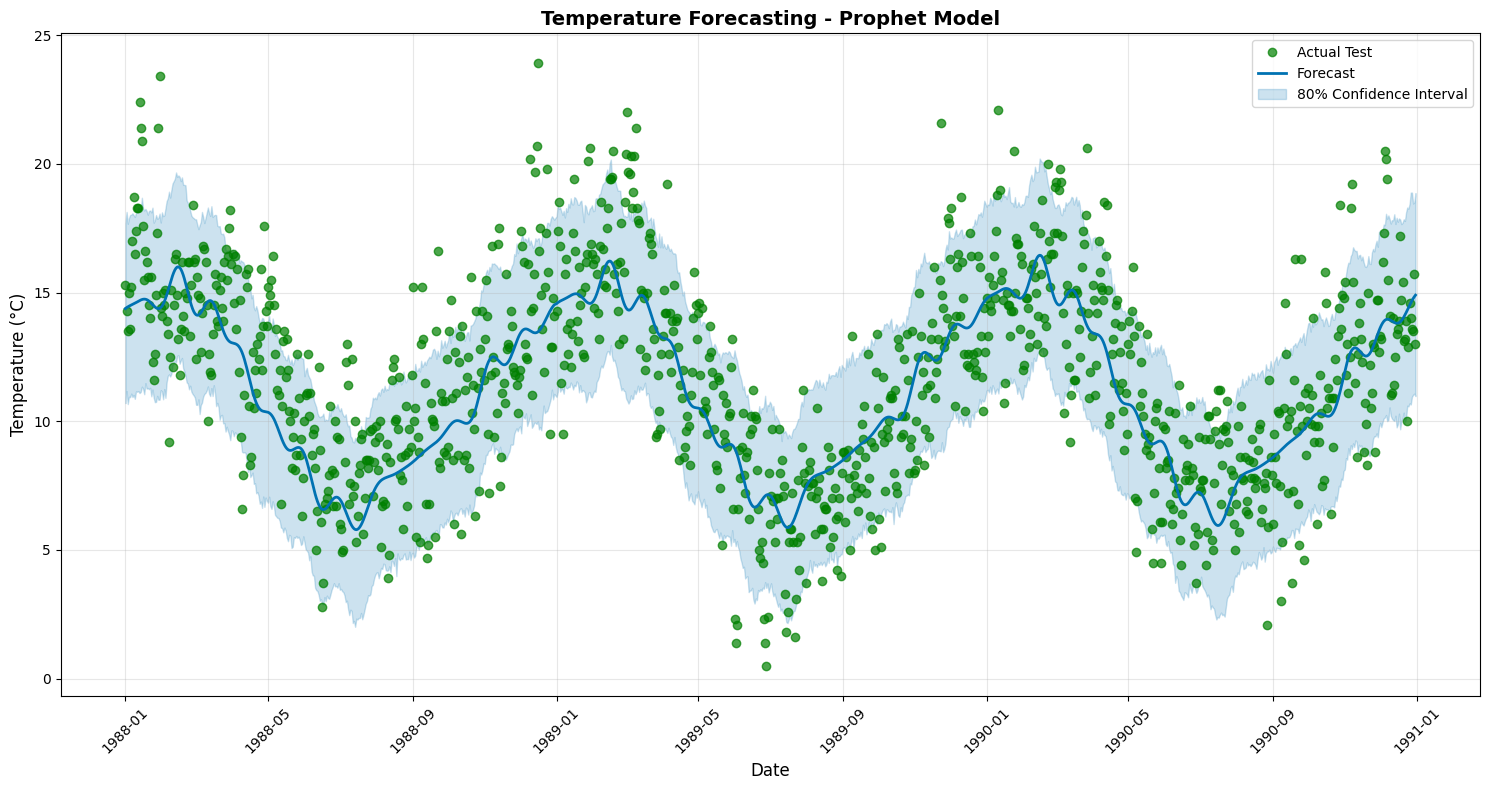

In [29]:
#Plot Time Series Graph Showing Test Part and Predicted Part.
def test_data_plot_timeseries(pred, test_data, lower_bound=None, upper_bound=None):
    fig = plt.figure(facecolor='w', figsize=(15, 8))
    ax = fig.add_subplot(111)
    
    # Plot test data as green dots
    ax.plot(test_data['ds'].values, test_data['y'], 'go', alpha=0.7, label="Actual Test")
    
    # Plot predictions as blue line
    ax.plot(test_data['ds'].values, pred, ls='-', c='#0072B2', linewidth=2, label="Forecast")
    
    # Fill confidence interval
    if lower_bound is not None and upper_bound is not None:
        ax.fill_between(test_data['ds'].values, lower_bound, upper_bound, 
                       color='#0072B2', alpha=0.2, label="80% Confidence Interval")
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title('Temperature Forecasting - Prophet Model', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return None

test_data_plot_timeseries(pred,test_data=test_data,lower_bound=lower_bound,upper_bound=upper_bound)